# Import

In [1]:
import os
import sys
import types
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
sys.path.append('../../../fiducial_detect')
sys.path.append('../../')

In [3]:
from fiducial_detect.data import *
from test_fast_inference.data import *
from test_fast_inference.pytorch_tensorrt_conversion import *

# Utility

In [4]:
def save_checkpoint(model, optimizer, metrics, file_checkpoint):
    file_checkpoint.parent.mkdir(exist_ok=True)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'metrics': metrics},
               file_checkpoint)

In [5]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    metrics = checkpoint['metrics']
    return model, optimizer, metrics

In [6]:
def train(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Train for an epoch
    model.train()
    for X, y in dl:
        X, y = X.to(device), y.to(device)
        
        # Optimize
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        # Get metrics scaled by batch size
        for key, metric in metrics.items():
            m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size
           
        # Track total number of items
        total_items += X.shape[0]
        
    # Get mean of metrics
    for key, metric in metrics.items():
        m[key] /= total_items
        
    return m

In [7]:
def validate(model, dl, loss, metrics, optimizer, device):
    m, total_items = dict.fromkeys(metrics.keys(), 0), 0
    
    # Validate
    model.eval()
    with torch.no_grad():
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            y_hat = model(X)

            # Get metrics scaled by batch size
            for key, metric in metrics.items():
                m[key] += metric(y_hat, y)*X.shape[0] # Scale by batch size

            # Track total number of items
            total_items += X.shape[0]

        # Get mean of metrics
        for key, metric in metrics.items():
            m[key] /= total_items

    return m

# Metrics

In [8]:
class MetricAccuracy():
    def __call__(self, y_hat, y):
        return (y_hat.argmax(dim=1) == y).float().mean().item()

In [9]:
class MetricErrorRate():
    def __call__(self, y_hat, y):
        return 1 - MetricAccuracy()(y_hat, y)

# Train

In [10]:
# Config
batch_size = 28
num_workers = 4
pin_memory = True
num_batches = 20
num_epochs = 500
lr = 1e-3
schedule = False

# Device
device = torch.device('cuda')

# Loss
loss = nn.functional.cross_entropy

# Metrics
metrics = {}
metrics['loss'] = lambda y_hat, y: loss(y_hat, y).item()
metrics['err'] = MetricErrorRate()

# Checkpoint metric
metric_checkpoint = 'err'

# Model
in_channels  = 1
out_channels = 5
layout_encoder = [[[32,5,2,2]],
                  [[32,3,1,1],[32,3,2,1]],
                  [[64,3,1,1],[64,3,2,1]],
                  [[128,3,1,1],[128,3,2,1]]]
model = UNET_TRT(get_encoder(in_channels, layout_encoder), out_channels)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

`SubsetSampler` will iterate over the 280,000 images in `batch_size*num_batches` sized epochs

In [11]:
class SubsetSampler(torch.utils.data.Sampler):
    def __init__(self, ds, batch_size, num_batches):
        self.idxs = np.split(np.arange(len(ds)), len(ds)/(batch_size*num_batches))
        self.idx_epoch = 0

    def __iter__(self):
        self.idx_epoch += 1 # Every call to iter() will increment
        for idx in self.idxs[self.idx_epoch-1]:
            yield(idx)

In [12]:
tfms_trn = Compose([FormatImg(),
                    ToTensor()])

ds_trn = RealMaskDataSet(Path('/data/fiducial_detect/trn/imgs'), tfms=tfms_trn)
dl_trn = DataLoader(ds_trn, 
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory,
                    sampler=SubsetSampler(ds_trn, batch_size, num_batches))

In [13]:
tfms_val = Compose([FormatImg(),
                    ToTensor()])

ds_val = RealMaskDataSet(Path('/data/fiducial_detect/val'), tfms=tfms_val)
dl_val = DataLoader(ds_val, 
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory)

In [14]:
%matplotlib notebook

# Training loop
df_metrics = pd.DataFrame(columns=['lr'] + 
                                  [str(key+'_trn') for key in metrics.keys()] +
                                  [str(key+'_val') for key in metrics.keys()])
m_checkpoint = np.inf # Initialize to arbitrarily high value
fig, axs = plt.subplots(df_metrics.shape[1], 1, figsize=(8,8))
for num_epoch in range(num_epochs):    
    # Train
    m_trn = train(model, dl_trn, loss, metrics, optimizer, device)
    
    # Validate
    m_val = validate(model, dl_val, loss, metrics, optimizer, device)
    
    # Step scheduler
    if schedule:
        scheduler.step(m_trn['loss'])
    
    # Store metrics
    df_metrics.loc[num_epoch, 'lr'] = np.mean([p['lr'] for p in optimizer.param_groups])
    for key, val in m_trn.items(): df_metrics.loc[num_epoch, key+'_trn'] = val
    for key, val in m_val.items(): df_metrics.loc[num_epoch, key+'_val'] = val
    
    # Print metrics
    print(df_metrics.iloc[[num_epoch]].to_string(header=num_epoch == 0,
                                                 float_format=lambda x: f'{x:10.5f}',
                                                 col_space=3), end='')
    
    # Checkpoint
    if m_val[metric_checkpoint] < m_checkpoint:
        print(f' - {metric_checkpoint} decreased; checkpointing...', end='')
        save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/best.pth'))
        m_checkpoint = m_val[metric_checkpoint]
        
    # Print newline
    print()
    
    # Plot stuff
    for idx, key in enumerate(df_metrics.columns):
        axs[idx].clear()
        axs[idx].plot(np.arange(num_epoch+1), df_metrics[key], label=key)
        axs[idx].legend(loc='upper left')
    fig.canvas.draw()
    
# Checkpoint last
print(f' - checkpointing last...')
save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/last.pth'))
    
%matplotlib inline

<IPython.core.display.Javascript object>

            lr   loss_trn    err_trn   loss_val    err_val
0      0.00100    1.20283    0.17499    0.66698    0.00909 - err decreased; checkpointing...
1      0.00100    0.27920    0.00628    0.07484    0.00909
2      0.00100    0.04011    0.00625    0.03113    0.00909
3      0.00100    0.02177    0.00614    0.02582    0.00909
4      0.00100    0.01876    0.00626    0.02453    0.00909
5      0.00100    0.01725    0.00616    0.02347    0.00909
6      0.00100    0.01660    0.00615    0.02328    0.00909
7      0.00100    0.01691    0.00648    0.02310    0.00909
8      0.00100    0.01580    0.00611    0.02326    0.00909
9      0.00100    0.01617    0.00640    0.02286    0.00909
10     0.00100    0.01582    0.00634    0.02189    0.00909
11     0.00100    0.01534    0.00616    0.02216    0.00909
12     0.00100    0.01501    0.00613    0.02157    0.00909
13     0.00100    0.01527    0.00633    0.02123    0.00909
14     0.00100    0.01497    0.00626    0.02128    0.00909
15     0.00100    0.01

127    0.00100    0.00895    0.00463    0.01389    0.00709
128    0.00100    0.00919    0.00474    0.01386    0.00709
129    0.00100    0.00944    0.00489    0.01378    0.00708
130    0.00100    0.00945    0.00483    0.01371    0.00707
131    0.00100    0.00925    0.00478    0.01375    0.00692 - err decreased; checkpointing...
132    0.00100    0.00929    0.00476    0.01363    0.00691 - err decreased; checkpointing...
133    0.00100    0.00934    0.00480    0.01375    0.00693
134    0.00100    0.00916    0.00468    0.01352    0.00690 - err decreased; checkpointing...
135    0.00100    0.00900    0.00463    0.01382    0.00709
136    0.00100    0.00929    0.00484    0.01377    0.00707
137    0.00100    0.00907    0.00468    0.01341    0.00701
138    0.00100    0.00927    0.00482    0.01364    0.00706
139    0.00100    0.00903    0.00467    0.01347    0.00702
140    0.00100    0.00888    0.00461    0.01360    0.00704
141    0.00100    0.00933    0.00486    0.01366    0.00705
142    0.0010

246    0.00100    0.00223    0.00046    0.00336    0.00071 - err decreased; checkpointing...
247    0.00100    0.00198    0.00043    0.00278    0.00049 - err decreased; checkpointing...
248    0.00100    0.00172    0.00037    0.00308    0.00073
249    0.00100    0.00180    0.00044    0.00259    0.00060
250    0.00100    0.00171    0.00045    0.00252    0.00056
251    0.00100    0.00164    0.00043    0.00197    0.00044 - err decreased; checkpointing...
252    0.00100    0.00150    0.00043    0.00233    0.00056
253    0.00100    0.00128    0.00034    0.00240    0.00060
254    0.00100    0.00107    0.00027    0.00240    0.00059
255    0.00100    0.00118    0.00033    0.00337    0.00116
256    0.00100    0.00099    0.00027    0.00161    0.00042 - err decreased; checkpointing...
257    0.00100    0.00097    0.00027    0.00195    0.00050
258    0.00100    0.00098    0.00028    0.00124    0.00033 - err decreased; checkpointing...
259    0.00100    0.00091    0.00027    0.00147    0.00041
260 

382    0.00100    0.00037    0.00014    0.00107    0.00037
383    0.00100    0.00032    0.00013    0.00141    0.00043
384    0.00100    0.00035    0.00013    0.00141    0.00043
385    0.00100    0.00031    0.00012    0.00160    0.00047
386    0.00100    0.00031    0.00012    0.00133    0.00042
387    0.00100    0.00029    0.00012    0.00179    0.00050
388    0.00100    0.00028    0.00011    0.00128    0.00041
389    0.00100    0.00030    0.00012    0.00148    0.00044
390    0.00100    0.00031    0.00012    0.00134    0.00041
391    0.00100    0.00031    0.00012    0.00143    0.00043
392    0.00100    0.00031    0.00012    0.00150    0.00045
393    0.00100    0.00034    0.00013    0.00143    0.00043
394    0.00100    0.00033    0.00013    0.00160    0.00049
395    0.00100    0.00031    0.00013    0.00179    0.00050
396    0.00100    0.00026    0.00011    0.00131    0.00041
397    0.00100    0.00026    0.00010    0.00151    0.00044
398    0.00100    0.00029    0.00011    0.00173    0.000

Validation error of `0.00028` similar in performance to the original fiducial detect network.

# Test

In [15]:
%matplotlib inline

In [16]:
model, optimizer, _ = load_checkpoint(model, optimizer, 'checkpoints/best.pth')

Inspect training dataset

In [18]:
X, y = ds_trn[0]
X, y = X[None].to(device), y.to(device)

In [19]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [20]:
idx = 0

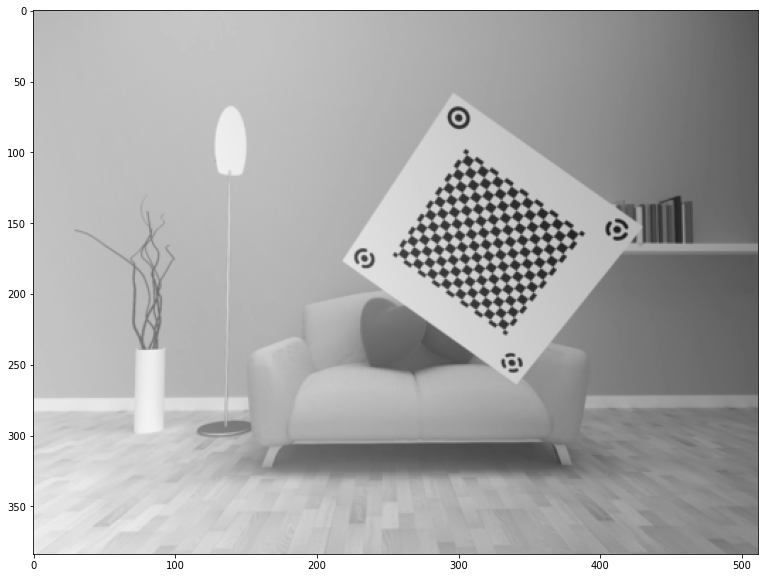

In [21]:
plt.figure(figsize=(15,10))
plt.imshow(X[idx,0,:,:].cpu().detach(), cmap='gray', vmin=-1, vmax=1)

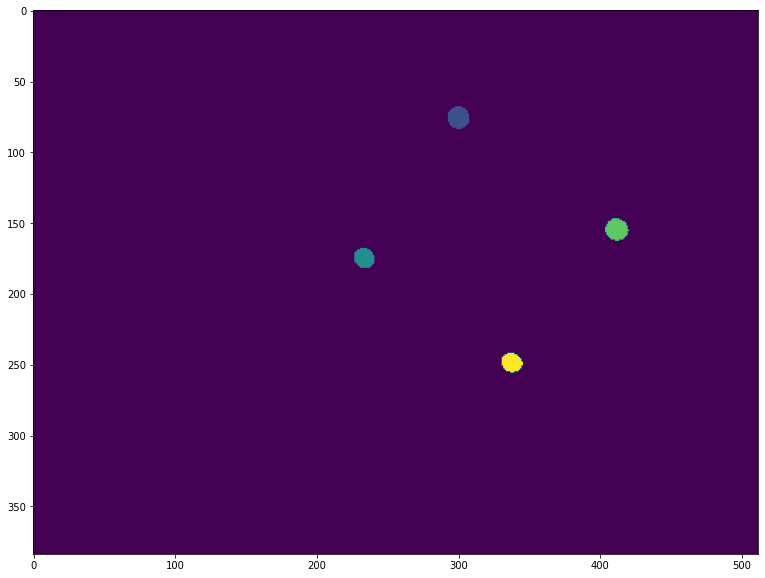

In [22]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

Inspect validation training set

In [23]:
X, y = next(iter(dl_val))
X, y = X.to(device), y.to(device)

In [24]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

In [25]:
idx = 0

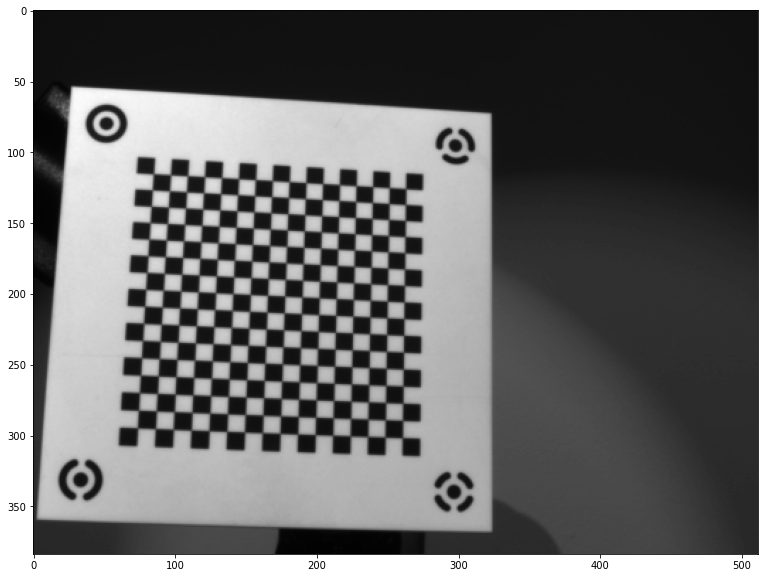

In [26]:
plt.figure(figsize=(15,10))
plt.imshow(X[idx,0,:,:].cpu().detach(), cmap='gray', vmin=-1, vmax=1)

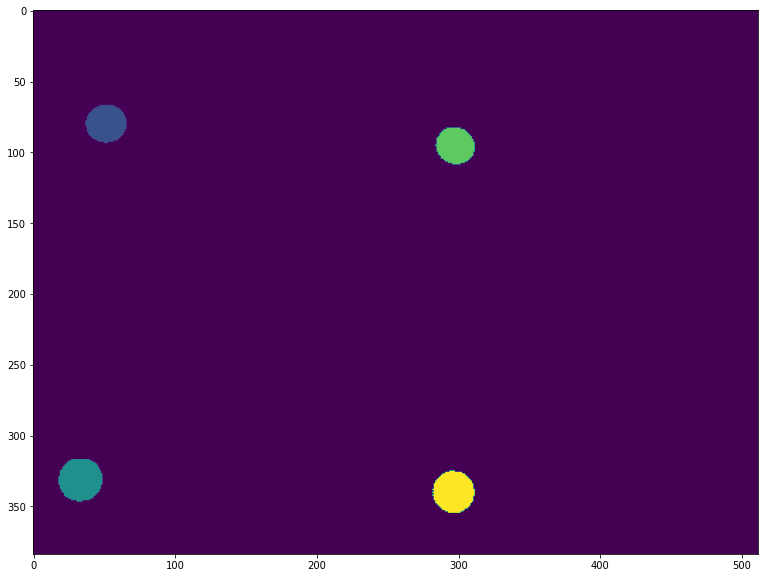

In [27]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx], vmin=0, vmax=4)

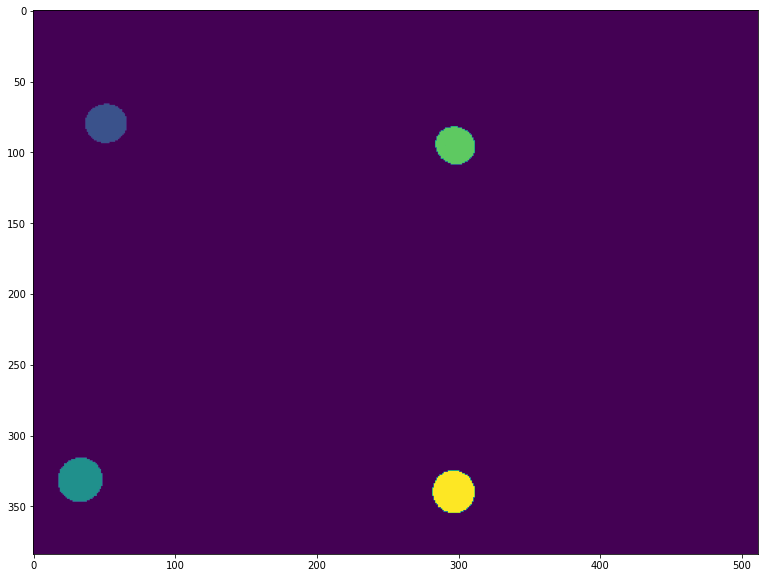

In [28]:
plt.figure(figsize=(15,10))
plt.imshow(y.cpu().detach()[idx], vmin=0, vmax=4)

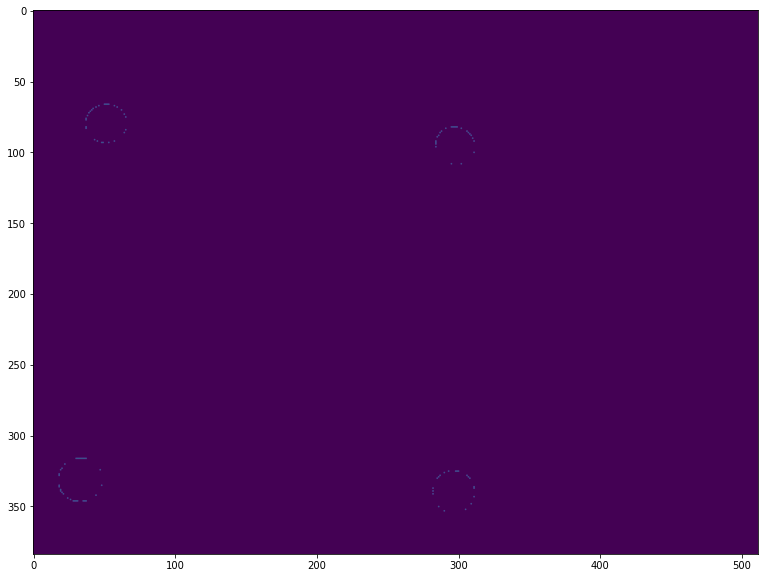

In [29]:
plt.figure(figsize=(15,10))
plt.imshow(y_hat.argmax(dim=1).cpu().detach()[idx] != y.cpu().detach()[idx], vmin=0, vmax=4)